In [1]:
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
import time
import sys 
import seaborn as sns
from sklearn.metrics import f1_score, recall_score
from tensorflow.keras.layers import AveragePooling2D
import cv2
import re
import pandas as pd
from utils import *
from scipy.linalg import hadamard

sys.path.append("./models/GPA")
from useful_functions import *
sys.path.append("./models/robust-pca-master/")
sys.path.append("./models/cspca/")

from cspca import CSPCA

In [2]:
dataset_name = "pedestrians"
result_path = f"./dataset/results/{dataset_name}"
img_path = f"./dataset/baseline/{dataset_name}/"
print(result_path, img_path)

./dataset/results/pedestrians ./dataset/baseline/pedestrians/


In [3]:
# Ground Truth Files
gt_files = glob.glob(img_path + "groundtruth/*png")
gt_files.sort()

# Raw Image Failes
raw_files = glob.glob(img_path + "input/*jpg")
raw_files.sort()

print(len(gt_files), len(raw_files))

1099 1099


In [4]:
def assert_same_gtraw(name1, name2):
    name1 = re.findall(r"gt.+\.png", name1)[0]
    index1 = re.findall("\d+", name1)[0]
    name2 = re.findall(r"in.+\.jpg", name2.split('/')[-1])[0]
    index2 = re.findall("\d+", name2)[0]
    assert index1 == index2

In [5]:
# Example Ground Truth
i = 950
gt_img = Image.open(gt_files[i])
gt_img = np.array(gt_img).astype(np.int32) / 255.0
gt_img = (gt_img > 0.5) * 1.0
gt_img.shape

(240, 360)

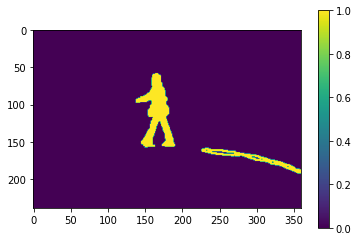

In [6]:
plt.imshow(gt_img)
plt.colorbar()

In [7]:
# Example Raw Image
raw_img = Image.open(raw_files[i])
raw_img = np.array(raw_img).astype(np.int32) / 255.0

In [8]:
p, q = raw_img.shape[0:2]

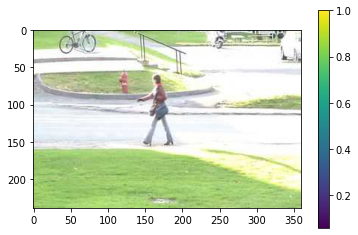

In [9]:
plt.imshow(raw_img)
plt.colorbar()

# CSPCA

In [10]:
import scipy.io
mat = scipy.io.loadmat('/mnt/MineSafe-2024/dataset/Hall.mat')

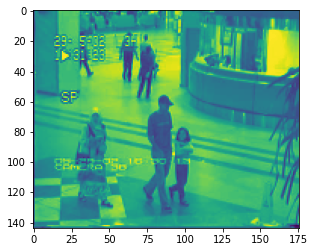

In [11]:
data = mat['Data']
plt.imshow(data[:, :, 0])
p, q, d = data.shape

In [12]:
p, q

(144, 176)

In [13]:
Data = np.zeros((d, p * q))

for k in range(d):
    raw_img = data[:, :, k]
    raw_vec = raw_img.ravel()
    Data[k] = raw_vec

In [14]:
Data.shape, Data.shape[1]

((100, 25344), 25344)

In [15]:
0.375 * p * q

9504.0

In [16]:
P = int(0.375 * p * q); P

9504

In [17]:
Phi = CSPCA.generate_measurement_matrix(k=32768, P=P, D=Data.shape[1])
Phi.shape  # (P, D)

(9504, 25344)

In [18]:
cspca_model = CSPCA(Data, Phi)

In [44]:
t1 = time.time()
Y_L, Y_S = cspca_model.L1_PCA(max_iter=1000)
t2 = time.time()
print(t2 - t1)

iteration: 1, error: 1238.3020356654424
iteration: 50, error: 7.360824299153534
iteration: 100, error: 0.6259996640021732
iteration: 150, error: 0.08713763148042263
iteration: 200, error: 0.01799653690096614
iteration: 250, error: 0.00540123500243345
iteration: 251, error: 0.005272028539248599
26.441192626953125


Our minimization problem is:

$$\min_{x_t \in R^{m \times n}} \mu \text{TV}_\text{2D}(x_t) + \frac{1}{2} \|Y_{t} - \Phi x_t\|_2^2,$$

where $l_t$ has the same length as the vector $x_t$.

In [ ]:
# t = 0
# y_t = Y_L[t]
# y_t.shape

# y_t = cspca_model.Y[0]
# x_t = Data[0]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


class TV:
    def __init__(self, y, Phi, m, n):
        self.y = y
        self.Phi = Phi
        self.m = m
        self.n = n
        self.x_est = None
    
    def get_diff_mat(self):
        m = self.m
        n = self.n
        Dh = np.zeros((n, n))
        Dv = np.zeros((m, m))
        for j in range(n-1):
            Dh[j, j] = -1
            Dh[j+1, j] = 1
        for i in range(m-1):
            Dv[i, i] = -1
            Dv[i, i+1] = 1
        return Dh, Dv
    
    def tv_2d(self, x):
        m = self.m
        n = self.n
        X = x.reshape(m, n)
        Dh, Dv = self.get_diff_mat()
        X_Dh = np.dot(X, Dh)
        Dv_X = np.dot(Dv, X)
        tv = np.sum(np.abs(X_Dh)) + np.sum(np.abs(Dv_X))
        G = self.get_subgradient(Dh, Dv, X_Dh, Dv_X)
        return tv, G
    
    def sign(self, X):
        sign_mat = np.zeros_like(X)
        sign_mat[X >= 0] = 1
        sign_mat[X < 0] = -1
        return sign_mat     
    
    def get_subgradient(self, Dh, Dv, X_Dh, Dv_X):
        G = np.transpose(Dv) @ self.sign(Dv_X) + self.sign(X_Dh) @ np.transpose(Dh)
        return G
    
    def fit(self, mu=1, step_size=5e-3, max_iter=100, tol=1e-4):
        X_est = x_t.reshape(self.m, self.n) * 0.9
        x_est = X_est.ravel()
        self.x_est = x_est * 1.0
        err = np.Inf
        loss_list = []
        
        for i in range(max_iter):
            tv, G = self.tv_2d(x_est)
            loss1 = mu * tv
            delta = self.y - self.Phi @ x_est
            loss2 = 0.5 * np.linalg.norm(delta)**2
            loss = loss1 + loss2
            loss_list.append(loss)
            
            tv_update = mu * G
            l2_update = -(np.transpose(self.Phi) @ delta).reshape(self.m, self.n)
            X_est -= step_size * (tv_update + l2_update)
            
            x_est = X_est.ravel()
            err = np.linalg.norm(self.x_est - x_est)
            print(f"Iter [{i}]: loss(tv):{loss1:.2f} + loss(l2):{loss2:.2f} = loss:{loss:.2f} \t error:{err:.4f}")
            self.x_est = x_est * 1.0
            if err < tol or err > 1e8:
                break

In [ ]:
# tv_model = TV(y_t, Phi, p, q)
# tv_model.fit(mu=25, step_size=5e-5, tol=3e-2)

In [35]:
t = 10
y_t = Y_L[t]
x_t = Data[t]

In [45]:
t1 = time.time()
tv_model = TV(y_t, Phi, p, q)
tv_model.fit(mu=1, step_size=5e-5, tol=0.02)
t2 = time.time()
print(t2 - t1)

Iter [0]: loss(tv):2318.25 + loss(l2):457560.67 = loss:459878.92 	 error:7.7730
Iter [1]: loss(tv):3563.02 + loss(l2):99392.40 = loss:102955.42 	 error:3.8664
Iter [2]: loss(tv):3003.26 + loss(l2):32883.05 = loss:35886.31 	 error:2.2563
Iter [3]: loss(tv):3300.13 + loss(l2):11740.44 = loss:15040.57 	 error:1.3698
Iter [4]: loss(tv):3130.04 + loss(l2):4536.99 = loss:7667.03 	 error:0.8460
Iter [5]: loss(tv):3227.48 + loss(l2):1695.12 = loss:4922.60 	 error:0.5278
Iter [6]: loss(tv):3164.37 + loss(l2):703.50 = loss:3867.87 	 error:0.3313
Iter [7]: loss(tv):3197.56 + loss(l2):257.10 = loss:3454.66 	 error:0.2091
Iter [8]: loss(tv):3171.16 + loss(l2):118.01 = loss:3289.17 	 error:0.1327
Iter [9]: loss(tv):3181.20 + loss(l2):39.73 = loss:3220.93 	 error:0.0848
Iter [10]: loss(tv):3168.43 + loss(l2):22.74 = loss:3191.17 	 error:0.0551
Iter [11]: loss(tv):3169.79 + loss(l2):6.94 = loss:3176.72 	 error:0.0368
Iter [12]: loss(tv):3162.26 + loss(l2):6.17 = loss:3168.43 	 error:0.0260
Iter [13]: 

In [37]:
np.linalg.norm(x_t - tv_model.x_est)

11.10533463807697

In [38]:
x_t, tv_model.x_est

(array([0.09411765, 0.45490196, 0.48627451, ..., 0.05098039, 0.02352941,
        0.04313725]),
 array([ 0.09515655,  0.46401911,  0.41578994, ...,  0.07203444,
        -0.02574957,  0.05547495]))

Text(0.5, 1.0, 'sparse foreground')

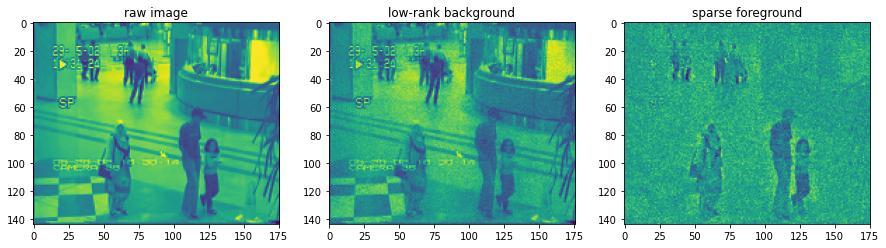

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(15, 15))

# raw image
a = x_t.reshape(p, q)
axs[0].imshow(a)
axs[0].set_title('raw image')

# low-rank background
b = tv_model.x_est.reshape(p, q)
axs[1].imshow(b)
axs[1].set_title('low-rank background')

# sparse foreground
c = a - b
axs[2].imshow(c)
axs[2].set_title('sparse foreground')

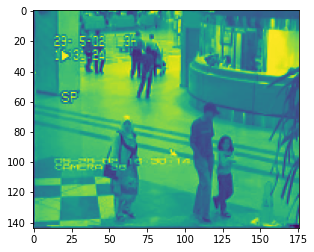

In [40]:
plt.imshow()

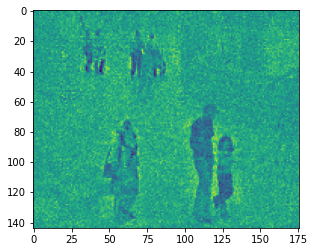

In [41]:
sparse = (x_t - tv_model.x_est).reshape(p, q)
plt.imshow(sparse)

In [20]:
t1 = time.time()
x_t = cp.Variable(p * q)
mu = cp.Parameter(nonneg=True)
problem = cp.Problem(cp.Minimize(objective_fn(x_t, y_t, Phi, mu, p, q)))

mu_values = [0.1]
errors = []
beta_values = []

for v in mu_values:
    mu.value = v
    problem.solve()
    errors.append(mse(x_t, y_t, Phi))

t2 = time.time()
#     beta_values.append(beta.value)

NameError: name 'cp' is not defined

In [24]:
errors

[0.01039930006695632]

In [ ]:
a = x_t.value
a = a.reshape(p, q)
plt.imshow(a)
plt.colorbar()
plt.show()

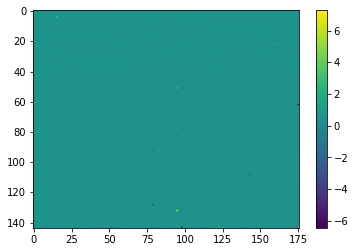

(25344,)

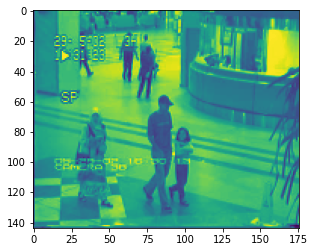

In [83]:
plt.imshow(data[:, :, 0])

In [60]:
X = np.ones((2, 2))
X[0] = 0
X

array([[0., 0.],
       [1., 1.]])

In [57]:
X.ravel()

array([0., 0., 1., 1.])

NameError: name 'D' is not defined

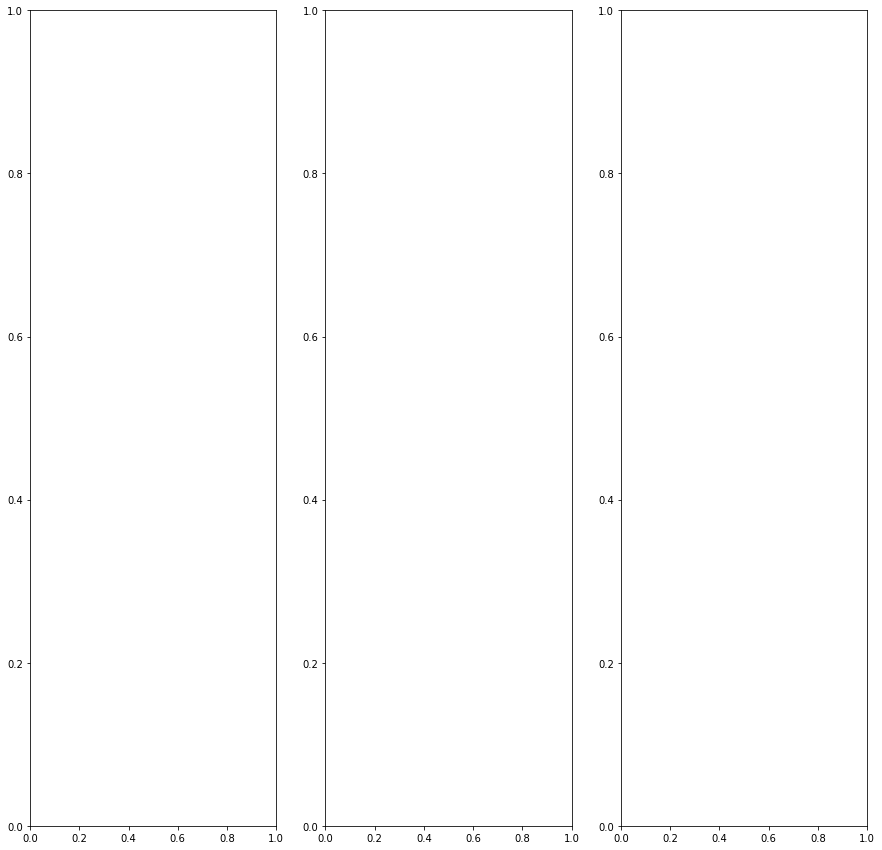

In [17]:
idx = 20

fig, axs = plt.subplots(1, 3, figsize=(15, 15))

# raw image
a = D[idx]
a = a.reshape((p, q))
axs[0].imshow(a)
axs[0].set_title('raw image')

# low-rank background
b = L[idx]
b = b.reshape((p, q))
axs[1].imshow(b)
axs[1].set_title('low-rank background')

# sparse foreground
c = S[idx]
c = c.reshape((p, q))
axs[2].imshow(c)
axs[2].set_title('sparse foreground')

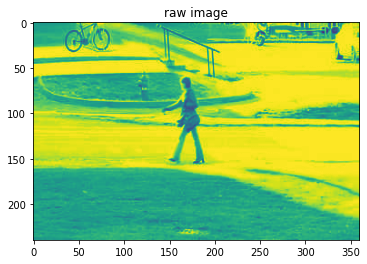

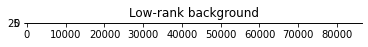

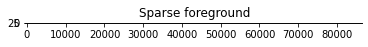

In [25]:
plt.imshow(raw_img)
plt.title("raw image")
plt.show()

plt.imshow(L)
plt.title("Low-rank background")
plt.show()

plt.imshow(S)
plt.title("Sparse foreground")
plt.show()